In [5]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from graphviz import Digraph

In [6]:
def f(x):
    return 3*x**2 - 4*x + 5

In [9]:
f(3.0)

20.0

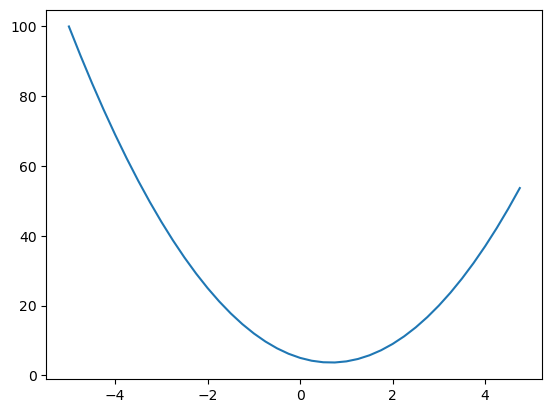

In [11]:
xs= np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)


In [13]:
h = 0.00000000000001
x=2/3
(f(x+h) -f(x))/h

0.0

In [15]:
# getting a little complex
a =2.0
b= -3.0
c= 10.0
d= a*b + c
print(d)

4.0


In [17]:
h = 0.0001

#inputs
a=2.0
b=-3.0
c=10.0

d1= a*b + c
b+=h
d2= a*b + c

In [19]:
print('d1',d1)
print('d2',d2)
print('slope',(d2-d1)/h)

d1 4.0
d2 4.0002
slope 2.0000000000042206


In [21]:
class Value:
    def __init__(self, data, _children=(), _op=' ',label=''):
        self.data=data
        self._prev= set(_children)
        self._backward = lambda: None
        self._op= _op
        self.grad = 0.0
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self,other):
        out=Value(self.data + other.data, (self, other), '+')
        def _backward():
          self.grad += 1.0 * out.grad
          other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        out=Value(self.data * other.data, (self, other), '*')
        def _backward():
          self.grad += other.data * out.grad
          other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def tanh(self):
        x= self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
          self.grad += (1 - t**2) * out.grad
        out._backward = _backward
    
        return out
        
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        build_topo(self)
       

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d= e + c; d.label = 'd'
f= Value(-2.0, label='f')
L= d * f; L.lable = 'L'
L

Value(data=-8.0)

In [23]:
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

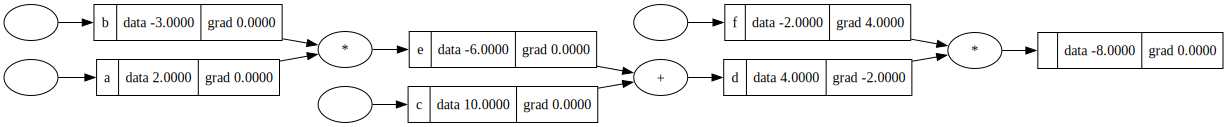

In [33]:
draw_dot(L)

L =d*f
* dL/dd = f


In [36]:
f.grad=4.0
d.grad= -2

In [38]:
def lol():
  
  h = 0.001
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  b.data += h
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data
  
  print((L2 - L1)/h)
  
lol()

-3.9999999999995595


dl /dc

* this is the manual backpropogation a we itrated through all the nodes one by one and locally applied the chain rule.
* we always know what is the derivative of L with respect to  this output.
* then we look at how this output was produced.
* thie output was produced by some operation.
* and we have the pointers to the children nodes to this opertions.
* and so in this little operation we know what the local derivatives are and we just multiply them onto the derivatives always.
* so we just go throught and recursively multiply on the local derivaties.
* and that what back propogation is.
* it is recursive application of chain rule backwords through the computation graph. 

now lets see this power in action just very briefly what we are going to do is, nudge our inputs to try to make L go up 

In [43]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f



so if we nudge in direction of the gradient we expect L go up positively. so it should be less negative.

In [46]:
print(L.data)

-7.84


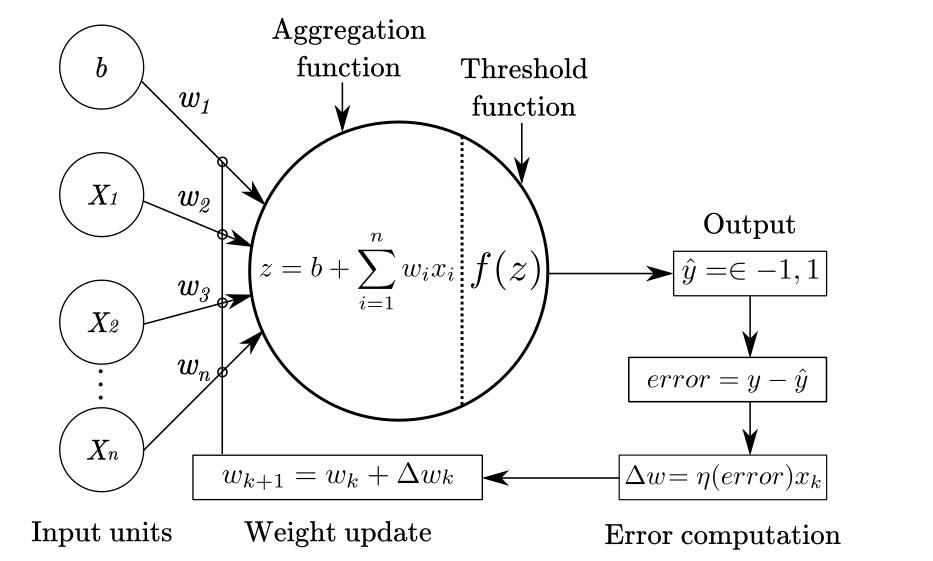

In [48]:
from IPython.display import Image
Image("img/perceptron.png")

* above is a representation of a perseptron.
* here X's are the inputs and W's are their weights.
* the W's intract with thue input multiplicatively so what flows to the cell body of this neuron is W times X.
* here there are multiple inputs so there will be many W times X's flowing into the cell.
* the cell body also has some bias b, so think of it as some kind of like the inert innate sort of trigger happiness of this neuron, so this buas can make a bit more trigger happy or a bit less brigger happy reguardless of input.
* but basically we are taking the w times x of all the inputs adding the bias. and this we take it through a activation function F(x).
* think of activation function as a some kind of squashing function.
* like a sigmoid or tanH

lets see tanH function below

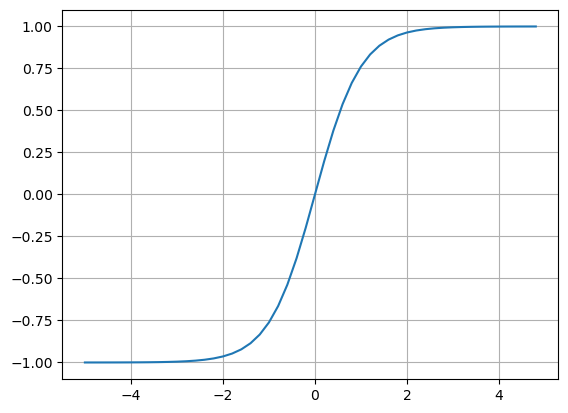

In [52]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

* so in this you can see x axis as input, and y axis the output of the tanH function
* as the the input come from -ve infinity to +ve infinity the tanH fucntion squashes the output between -1 and 1.

now lets see a neuron in action 

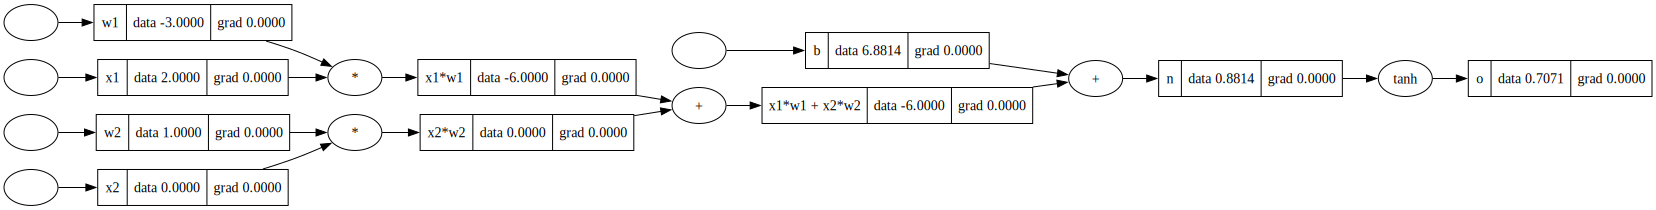

In [56]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o' #here we are taking out n through an activation function, we have implemented tanh function in the value class 
draw_dot(o)

* in the above code,
* x1, x2 are the inputs.
* w1, w2 are the weights.
* b is the bias.
* now inputs gets multiplied by the synaptic weights
* and the bias is added to their sum and stored in n.
* now this n is passed through tanh function.

so now lets begin the backpropogation 

In [60]:
o.grad =1.0

so to backpropogate throught tanh we need to know the local derivative of tanh.
* o= tanh(n)
* do/dn = 1 - o^2

In [63]:
1- o.data**2

0.4999999999999999

In [65]:
n.grad = 0.5

now the next backword operation is +, we know from our previous example that + is just distributor of gradien, so the gradient will flow to both of the gradient equally.
* and thats because the local derivative of this perticular operation is 1 for every one of its nodes.

In [68]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

the next operation is + as well so the same repeats 

In [71]:
x1w1.grad = 0.5
x2w2.grad = 0.5

dl/x2= (dl/dw2x2)*(dw2x2/dx2)

In [73]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [75]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

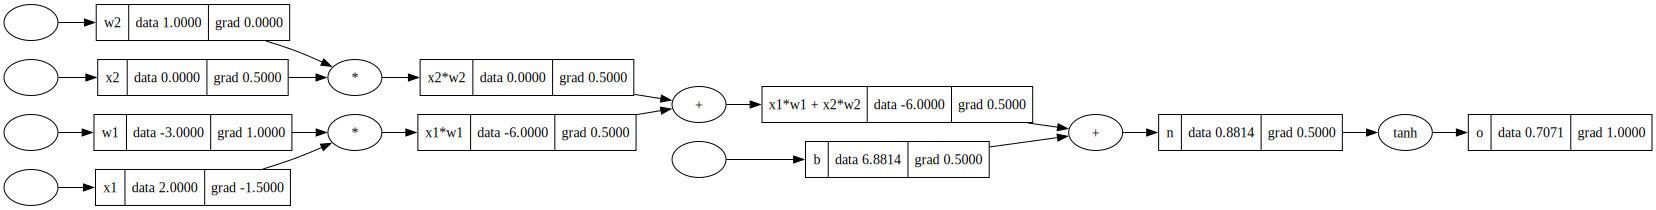

In [115]:
draw_dot(o)

so this is how we did back propogation manually.

# implementing backward function for each operation.
here we are going to see how can we implement the backward passs a bit autometically.
* now its pretty obvious to us how these +s and times are backprapogating.
* go back the the value class and look at self._backward = lambda: None in the __init__ function, this is the function that is going to do that little piece of chain rule at each little node that compute that took inputs and produced output.
* so we are going to store how we are going to store how we are going to chain the outputs gradient into the inputs gradients.
* this is basically an empty function that by default does nothing.
* it would be for the case for leaf node.


### For addition
def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

this snippet for the addition operation:
* the out values are the addition of self and other.
* so we set out's _backeard to be that propagates the gradients.
* we directly take out's grad and pass it to self's grad and other's grad.
* will later call this function having done addition

### For multiplication
  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad = other.data * out.grad
      other.grad = self.data * out.grad
    out._backward = _backward
      
    return out
we saw this in the manual back propagationn.
* x2.grad = w2.data * x2w2.grad
* w2.grad = x2.data * x2w2.grad

### For Tanh

    def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def backward(self):
  

now lets redefine the expressions 

In [85]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [87]:
o.grad =1.0

In [89]:
o._backward()
n._backward()

In [91]:
b._backward()

In [93]:
x1w1x2w2._backward()

In [95]:
x1w1._backward()
x2w2._backward()

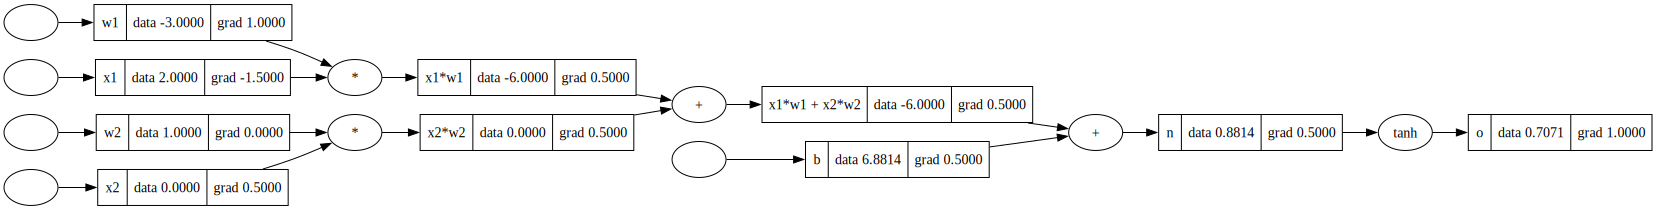

In [97]:
draw_dot(o)

so now lets try to automate the backward calling operation, means that we just never have to call the backward for any node, 
that is everything that it depends on has to forward propagate before we can continue back propagation so thi ordering of graphs can be achieved by simething called **topological sort**.
* Backpropagation requires that gradients are computed in reverse topological order (i.e., starting from the output node and moving backward through the graph). The topological sort ensures that all dependencies of a node are processed before the node itself, which is crucial for correctly computing gradients.



This function performs a topological sort on a directed acyclic graph (DAG). It ensures that nodes are processed in an order where all dependencies (parent nodes) are resolved before the node itself. This is crucial for tasks like forward/backward passes in neural networks or dependency resolution in computational graphs.
* If v hasn’t been processed, proceed. Otherwise, skip it to avoid redundant work.
* Add v to the visited set to ensure it’s not processed again.
* Recursively call build_topo on each parent node (child) to ensure all dependencies are resolved before processing v.
* Once all parents are processed, add v to the topo list. This ensures v appears after its dependencies.

lets redefine the values and call the backward() function on o

In [102]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

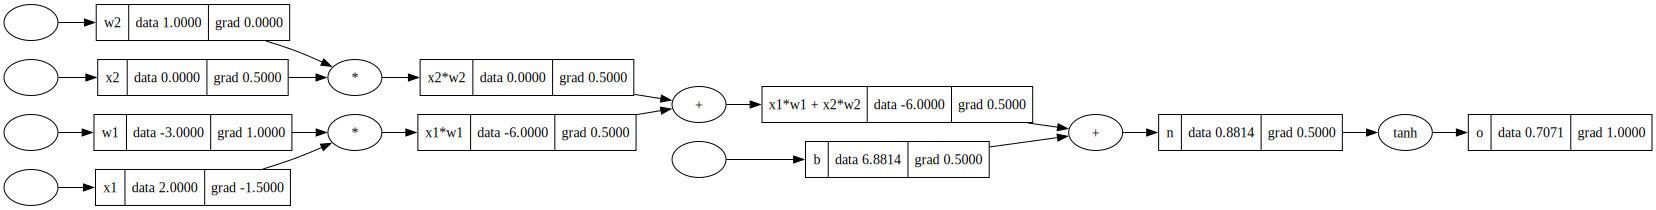

In [104]:
o.backward()
draw_dot(o)

now here we have a bug, and below is the case to show the bug

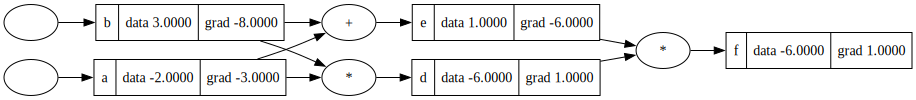

In [107]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

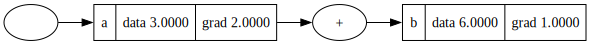

In [109]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

in this example the variabele a and b are used twice.
* once in a+b
* a * b
* During backpropagation, gradients are computed for each node and propagated backward through the graph.
* The bug occurs because the gradients for a and b are overwritten instead of accumulated when they are used multiple times.

In [112]:
pip install torch

Note: you may need to restart the kernel to use updated packages.
